# VAR USA

Vector auto-regressive models

1. [Imports](#imports)
2. [Ingestion](#ingestion)
3. [Plotting](#plotting)
4. [Statistical tests](#stattests1)
5. [Differencing](#diff)


### VAR with First-Order Differencing
1. [Train test split - first order differencing](#traintest1)
2. [Find order p of VAR](#var_p_1)
3. [VAR(8) Model](#var8_1)
4. [Plots of first differenced predictions](#diff1_plot)
5. [Undifferencing and predicting](#undiff_1)
6. [MAPE](#mape1)
7. [Rolling forecasts](#roll1)


### VARMA
1. [VARMA](#varma)
2. [Rolling forecasts](#roll2)

<a name=imports></a>
## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<a name=ingestion></a>
## Ingestion

In [2]:
daily_cases_usa = pd.read_csv('../../cleaned_datasets/usa/daily_cases_usa.csv', parse_dates=['Date'])
daily_vacc_usa = pd.read_csv('../../cleaned_datasets/usa/daily_vacc_usa.csv', parse_dates=['date'])

In [3]:
daily_cases_usa.dtypes

Date         datetime64[ns]
Confirmed           float64
Deaths              float64
Recovered           float64
dtype: object

In [4]:
daily_vacc_usa.dtypes

date           datetime64[ns]
Total_Doses           float64
dtype: object

In [5]:
daily_cases_usa

,Date,Confirmed,Deaths,Recovered
0,2020-04-14,26713.0,2305.0,6484.0
1,2020-04-15,29380.0,2478.0,6093.0
2,2020-04-16,31542.0,4616.0,5234.0
3,2020-04-17,32022.0,3879.0,5904.0
4,2020-04-18,32502.0,1859.0,13591.0
...,...,...,...,...
542,2021-10-08,131142.0,1837.0,0.0
543,2021-10-09,27501.0,279.0,0.0
544,2021-10-10,22194.0,255.0,0.0
545,2021-10-11,116202.0,1182.0,0.0


In [6]:
daily_vacc_usa

,date,Total_Doses
0,2020-12-20,NaN
1,2020-12-21,57909.0
2,2020-12-22,196954.0
3,2020-12-23,196954.0
4,2020-12-24,468280.0
...,...,...
292,2021-10-08,5047253.0
293,2021-10-09,2321346.0
294,2021-10-10,1769478.0
295,2021-10-11,884739.0


In [7]:
cases_vacc = daily_cases_usa.merge(daily_vacc_usa, how='outer', left_on='Date', right_on='date')
cases_vacc = cases_vacc[["Date", "Confirmed", "Total_Doses"]]
cases_vacc

,Date,Confirmed,Total_Doses
0,2020-04-14,26713.0,NaN
1,2020-04-15,29380.0,NaN
2,2020-04-16,31542.0,NaN
3,2020-04-17,32022.0,NaN
4,2020-04-18,32502.0,NaN
...,...,...,...
542,2021-10-08,131142.0,5047253.0
543,2021-10-09,27501.0,2321346.0
544,2021-10-10,22194.0,1769478.0
545,2021-10-11,116202.0,884739.0


In [8]:
cases_vacc.fillna(0, inplace=True)
indexed = cases_vacc.set_index('Date')
indexed

,Confirmed,Total_Doses
Date,,
2020-04-14,26713.0,0.0
2020-04-15,29380.0,0.0
2020-04-16,31542.0,0.0
2020-04-17,32022.0,0.0
2020-04-18,32502.0,0.0
...,...,...
2021-10-08,131142.0,5047253.0
2021-10-09,27501.0,2321346.0
2021-10-10,22194.0,1769478.0


<a name=plotting></a>
## Plot initial data

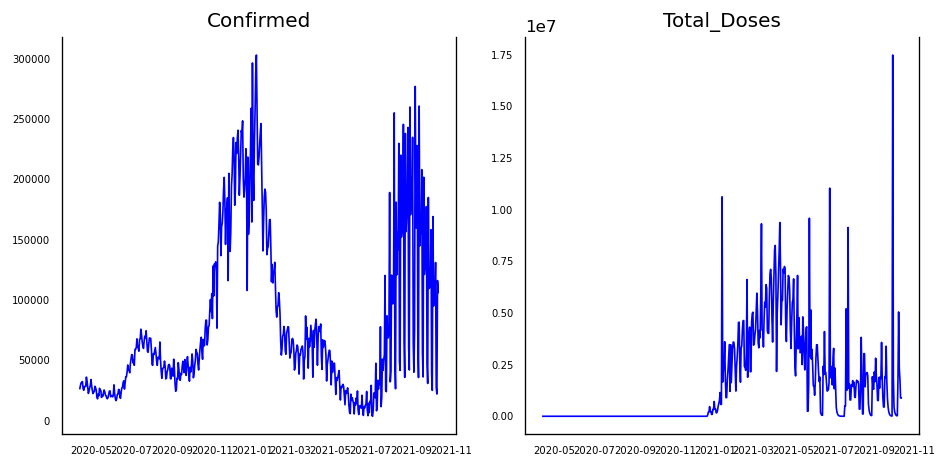

In [9]:
def plot_subplots(indexed):
    
    if type(indexed) == pd.DataFrame:
        nrows = int(len(indexed.columns)/2)
    else:
        nrows = 1
        
    fig, axes = plt.subplots(nrows=nrows, ncols=2, dpi=120, figsize=(8,4))
    for i, ax in enumerate(axes.flatten()):
        
        if type(indexed) == list:
            # fig, ax = plt.subplots()
            # fig.set_size_inches(8, 8)

            ax.plot(indexed[0][indexed[0].columns[i]], color='blue', label = 'Train')
            ax.plot(indexed[1][indexed[1].columns[i]], color='red', label = 'Test')
            ax.legend(loc = 'best')
            # Decorations
            ax.set_title(indexed[0].columns[i])
        else:    
            data = indexed[indexed.columns[i]]
            ax.plot(data, color='blue', linewidth=1)
            # Decorations
            ax.set_title(indexed.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)
    
    plt.tight_layout()
    
plot_subplots(indexed)

<a name=stattests1></a>
## Statistical tests

### Johansen co-integration test

In [10]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(indexed)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  8.76      > 12.3212   =>   False
Total_Doses ::  1.19      > 4.1296    =>   False


### Augmented DF Test

In [11]:
from statsmodels.tsa.stattools import adfuller

def run_dicky_fuller(ts):
  '''Function to run Augmented Dicky Fuller test on the passed time series and report the statistics from the test'''
  print("Observations of Dickey-fuller test")
  dftest = adfuller(ts,autolag='AIC')
  dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])

  for key,value in dftest[4].items():
      dfoutput['critical value (%s)'%key]= value
  print(dfoutput)


# ADF Test on each column
for name, column in indexed.iteritems():
    run_dicky_fuller(column)
    print('\n')

Observations of Dickey-fuller test
Test Statistic                  -1.792201
p-value                          0.384341
#lags used                      13.000000
number of observations used    533.000000
critical value (1%)             -3.442678
critical value (5%)             -2.866978
critical value (10%)            -2.569666
dtype: float64


Observations of Dickey-fuller test
Test Statistic                  -1.291710
p-value                          0.632956
#lags used                      19.000000
number of observations used    527.000000
critical value (1%)             -3.442820
critical value (5%)             -2.867040
critical value (10%)            -2.569699
dtype: float64




The TS is not stationary

<a name=diff></a>
## Differencing

## First order differencing

In [12]:
df_diff_1 = indexed.diff().dropna()
df_diff_1

,Confirmed,Total_Doses
Date,,
2020-04-15,2667.0,0.0
2020-04-16,2162.0,0.0
2020-04-17,480.0,0.0
2020-04-18,480.0,0.0
2020-04-19,-5914.0,0.0
...,...,...
2021-10-08,31059.0,3269635.0
2021-10-09,-103641.0,-2725907.0
2021-10-10,-5307.0,-551868.0


In [13]:
# ADF Test on each column
for name, column in df_diff_1.iteritems():
    run_dicky_fuller(column)
    print('\n')

Observations of Dickey-fuller test
Test Statistic                  -4.256256
p-value                          0.000528
#lags used                      19.000000
number of observations used    526.000000
critical value (1%)             -3.442843
critical value (5%)             -2.867050
critical value (10%)            -2.569705
dtype: float64


Observations of Dickey-fuller test
Test Statistic                -7.652382e+00
p-value                        1.775213e-11
#lags used                     1.800000e+01
number of observations used    5.270000e+02
critical value (1%)           -3.442820e+00
critical value (5%)           -2.867040e+00
critical value (10%)          -2.569699e+00
dtype: float64




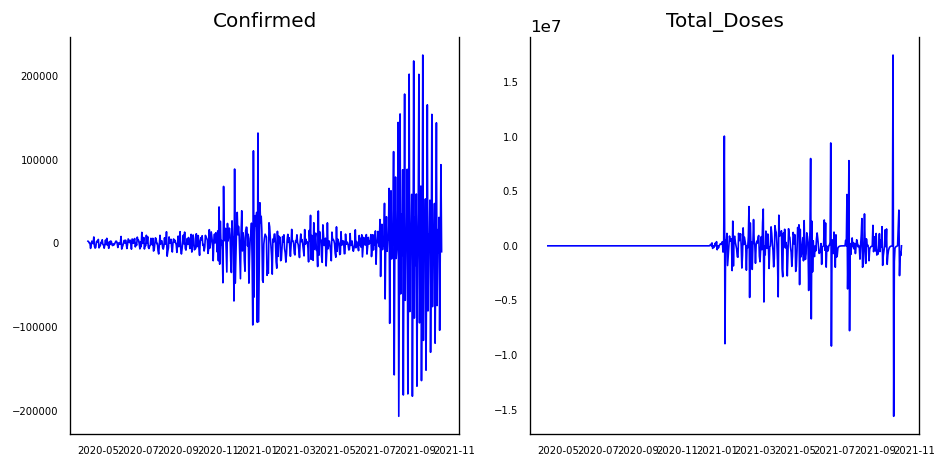

In [14]:
plot_subplots(df_diff_1)

Even though the data seems to be stationary, there are 2 small sinusoids corresponding with the two waves of cases. Therefore, 2nd order differencing might be required.

<a name=traintest1></a>
## Train-test split

### Train-test split - first order differenced

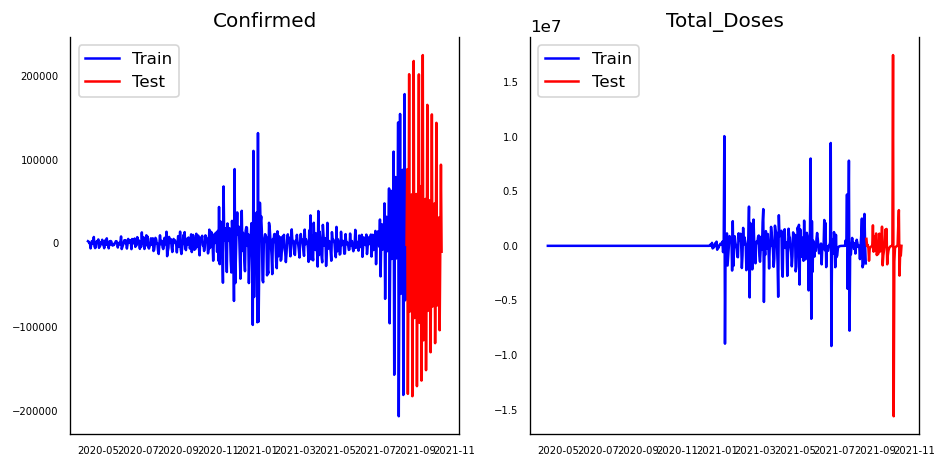

In [15]:
percent_90 = int(len(df_diff_1)*0.9)

train = df_diff_1.iloc[:percent_90].dropna()
test = df_diff_1.iloc[percent_90:]

plot_subplots([train, test])

<a name=var_p_1></a>
### Finding the best value of p for VAR(p)

Using AIC, BIC, FPE, HQIC

In [16]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(train)

x = model.select_order(maxlags=25)
x.summary()

/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


,AIC,BIC,FPE,HQIC
0,48.95,48.97,1.817e+21,48.96
1,48.65,48.70,1.340e+21,48.67
2,48.41,48.50,1.062e+21,48.45
3,48.34,48.47,9.877e+20,48.39
4,48.26,48.42,9.126e+20,48.33
5,48.19,48.38,8.467e+20,48.26
6,47.77,48.00,5.587e+20,47.86
7,47.54,47.80,4.416e+20,47.64
8,47.39,47.69*,3.816e+20,47.51
9,47.39,47.73,3.816e+20,47.52


At p = 8 the value of BIC and HQIC are at their local minima

<a name=var8_1></a>
### VAR(8) Model

In [17]:
model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 13, Dec, 2021
Time:                     12:34:47
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    47.6094
Nobs:                     483.000    HQIC:                   47.4308
Log likelihood:          -12763.3    FPE:                3.53793e+20
AIC:                      47.3152    Det(Omega_mle):     3.30144e+20
--------------------------------------------------------------------
Results for equation Confirmed
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                470.806562       717.464734            0.656           0.512
L1.Confirmed          -0.679409         0.042737          -15.898           0.000
L1.Total_Doses        -0.000899         0.000629    

In [18]:
forecast_input = test.values


forecast_input
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=len(forecast_input))


df_forecast = pd.DataFrame(fc, index=test.index, columns=test.columns + '_forecast')

forecasted_conf = df_forecast.join(test)[['Confirmed', 'Confirmed_forecast']]
forecasted_vacc = df_forecast.join(test)[['Total_Doses', 'Total_Doses_forecast']]

<a name=diff1_plot></a>
### Plot Predictions on Diffed

In [19]:
def plot_fore_test(test, fore, title):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 7)

    ax.plot(test, color='blue', label='Test')
    ax.plot(fore, color='red', label='Forecast')
    ax.legend(loc='best')
    plt.title(title)
    plt.show()


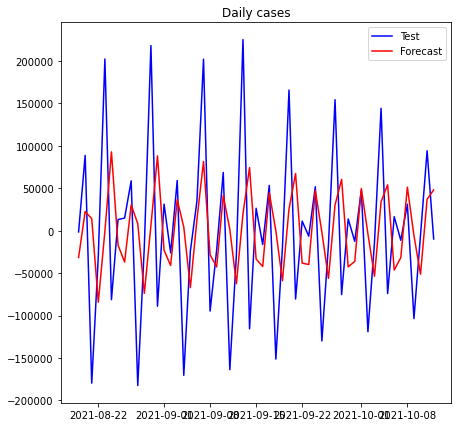

In [20]:
plot_fore_test(forecasted_conf[['Confirmed']], forecasted_conf[['Confirmed_forecast']], title='Daily cases')

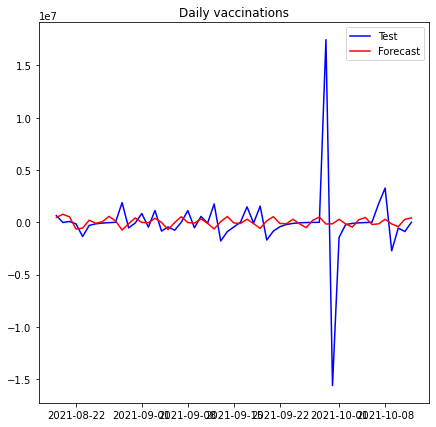

In [21]:
plot_fore_test(forecasted_vacc[['Total_Doses']], forecasted_vacc[['Total_Doses_forecast']], title='Daily vaccinations')

<a name=undiff_1></a>

## Un-differencing and Plotting

In [22]:
def invert_transformation(diffed, original):
    """Revert back the differencing to get the forecast to original scale."""
    df_copy = original.copy()
    
    columns = diffed.columns
    
    for col in columns:
        # Add corresponding diff column
        df_copy[f'undiff_{col}'] = original[col]
        df_copy[f'undiff_{col}'][1:] = diffed[col]
        df_copy[f'undiff_{col}'] = df_copy[f'undiff_{col}'].cumsum()
    
        df_copy.drop(col, axis=1, inplace=True)
        
    return df_copy

In [23]:
# Check if un-diffed df_diff_1 is the same as original

#inverted = invert_transformation(df_diff_1, indexed)
#(inverted[['undiff_Confirmed']] - indexed[['Confirmed']]).isna().sum()

In [24]:
# Un-diff the test dataset

start_index = indexed.index.get_loc(test.index[0])-1
test_original = invert_transformation(test, indexed.iloc[start_index:])

#test_original

In [25]:
renamed_df = df_forecast.rename(columns={'Confirmed_forecast': 'Confirmed', 'Total_Doses_forecast': 'Total_Doses'}, inplace=False)


start_index = indexed.index.get_loc(renamed_df.index[0])-1
fore_original = invert_transformation(renamed_df, indexed.iloc[start_index:])

#fore_original

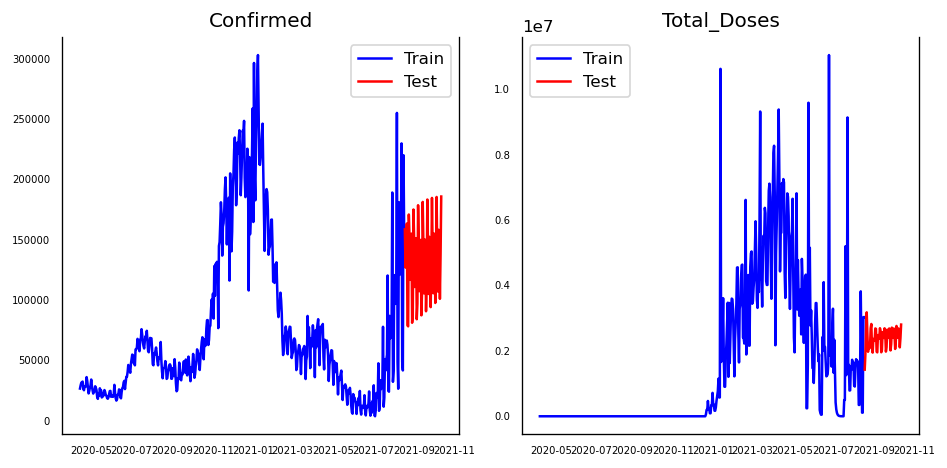

In [26]:
end_index = indexed.index.get_loc(fore_original.index[0])
train_original = indexed[:end_index]
plot_subplots([train_original, fore_original])

### Plot the forecasts

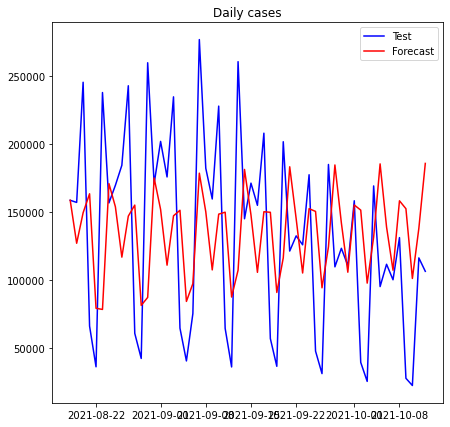

In [27]:
plot_fore_test(test_original[['undiff_Confirmed']], fore_original[['undiff_Confirmed']], title='Daily cases')

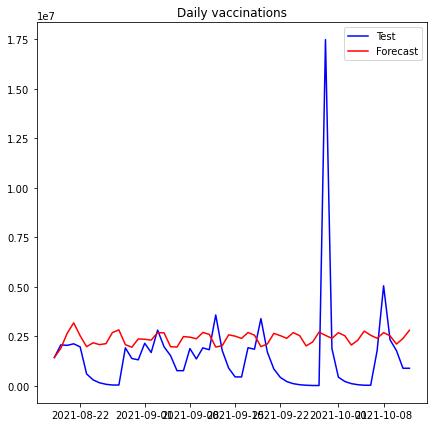

In [28]:
plot_fore_test(test_original[['undiff_Total_Doses']], fore_original[['undiff_Total_Doses']], title='Daily vaccinations')

In [29]:
def plot_train_test_fore(train, test, fore, title='Forecast vs Actuals', ylabel='', xlabel='Date', figpath=None):
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fore, label='forecast')
    fig = plt.gcf()
    
    plt.xlabel=xlabel
    plt.ylabel=ylabel

    plt.title(title)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    
    if figpath is not None:
        fig.savefig(figpath, format='eps', bbox_inches='tight')

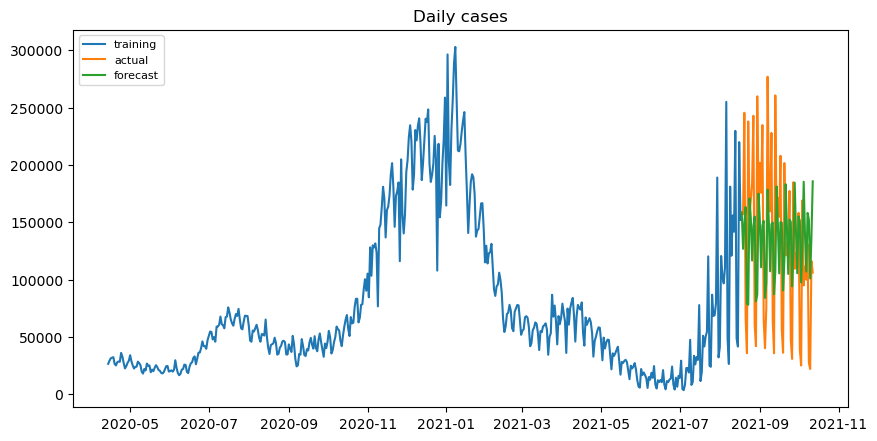

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [30]:
# Plot of daily cases
plot_train_test_fore(train_original.Confirmed, test_original[['undiff_Confirmed']], fore_original[['undiff_Confirmed']], title='Daily cases', figpath='../../figures/v_ar/usa_cases.eps')



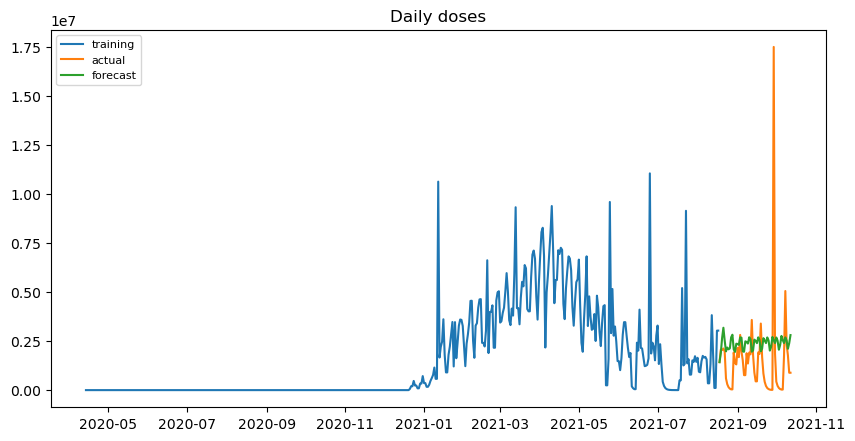

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [31]:
# Plot of daily cases
plot_train_test_fore(train_original.Total_Doses, test_original[['undiff_Total_Doses']], fore_original[['undiff_Total_Doses']], title='Daily doses', figpath='../../figures/v_ar/usa_vacc.eps')




<a name=mape1></a>
### MAPE

In [32]:
def MAPE(Y_actual,Y_Predicted, title):
    mask = Y_actual != 0
    
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual)[mask])*100
    print(f"MAPE of {title} is {mape[mape.index[0]]}%")
    return mape[mape.index[0]]


mape_vacc = MAPE(test_original[['undiff_Total_Doses']], fore_original[['undiff_Total_Doses']], title="Daily vaccinations")
mape_cases = MAPE(test_original[['undiff_Confirmed']], fore_original[['undiff_Confirmed']], title="Daily cases")

MAPE of Daily vaccinations is 1830.6520073057332%
MAPE of Daily cases is 78.02438218180782%


In [33]:
from sklearn.metrics import mean_absolute_error


mean_absolute_error(test_original[['undiff_Confirmed']], fore_original[['undiff_Confirmed']])

60142.44002621117

Clearly, a VAR model is not good enough to make predictions

<a name=varma></a>

## VARMA

In [34]:
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error

# evaluate an VARMA model for a given order (p,d,q)
def evaluate_varma_model(train, test, varma_order):
    
    model = VARMAX(train, order=varma_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(len(test))
    error = mean_squared_error(test, yhat)
    return error

In [35]:
# Grid search


# evaluate combinations of p and q values for an VARMA model
def evaluate_models(train, test, p_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    
    for p in p_values:
        for q in q_values:
            order = (p,q)
            try:
                mse = evaluate_varma_model(train, test, order)
                if mse < best_score:
                    best_score, best_cfg = mse, order
                print('VARMA%s MSE=%.3f' % (order,mse))
            except:
                continue
    print()
    print('Best VARMA%s MSE=%.3f' % (best_cfg, best_score))

In [36]:
import warnings
warnings.filterwarnings("ignore")

p_values = range(1, 3)
q_values = range(1, 3)

evaluate_models(train, test, p_values, q_values)

VARMA(1, 1) MSE=5460991206879.037
VARMA(1, 2) MSE=5460602483034.451
VARMA(2, 1) MSE=5461668651664.556
VARMA(2, 2) MSE=5460658896510.228

Best VARMA(1, 2) MSE=5460602483034.451


In [37]:
from statsmodels.tsa.statespace.varmax import VARMAX

model = VARMAX(train, order=(1,1))
model_fit = model.fit()
yhat = model_fit.forecast(len(test))
#yhat

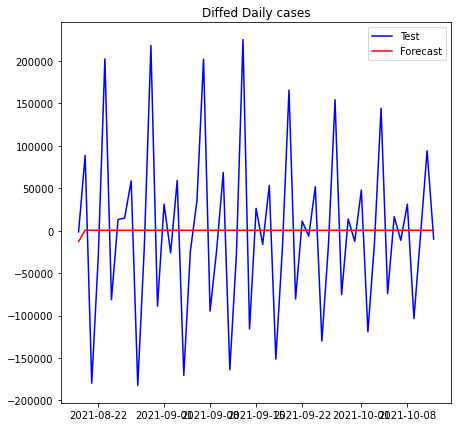

In [38]:
plot_fore_test(test[['Confirmed']], yhat[['Confirmed']], title='Diffed Daily cases')

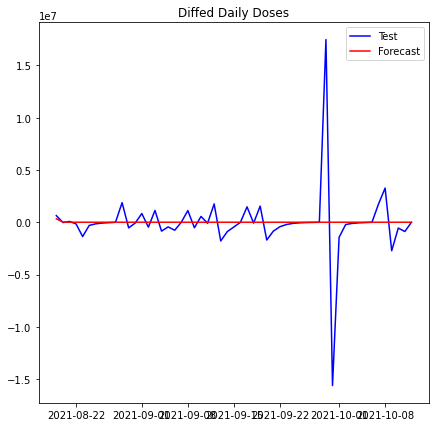

In [39]:
plot_fore_test(test[['Total_Doses']], yhat[['Total_Doses']], title='Diffed Daily Doses')

In [40]:

# Un-diff the test dataset

fore_original_3 = invert_transformation(yhat, indexed.iloc[start_index:])
fore_original_3

,undiff_Confirmed,undiff_Total_Doses
Date,,
2021-08-18,158637.000000,1.424863e+06
2021-08-19,145758.640527,1.758994e+06
2021-08-20,146160.561882,1.778144e+06
2021-08-21,146561.454399,1.786227e+06
2021-08-22,146951.391319,1.792291e+06
2021-08-23,147339.076590,1.797947e+06
2021-08-24,147726.307784,1.803522e+06
2021-08-25,148113.447440,1.809080e+06
2021-08-26,148500.568643,1.814635e+06


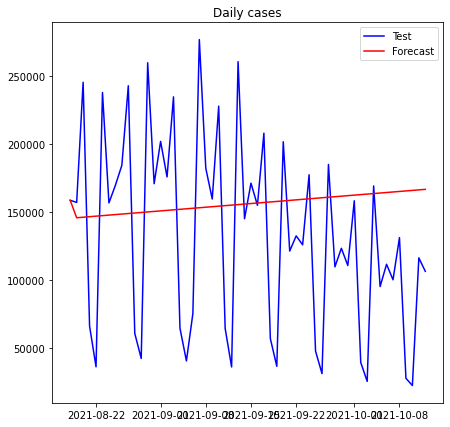

In [41]:
plot_fore_test(test_original[['undiff_Confirmed']], fore_original_3[['undiff_Confirmed']], title='Daily cases')

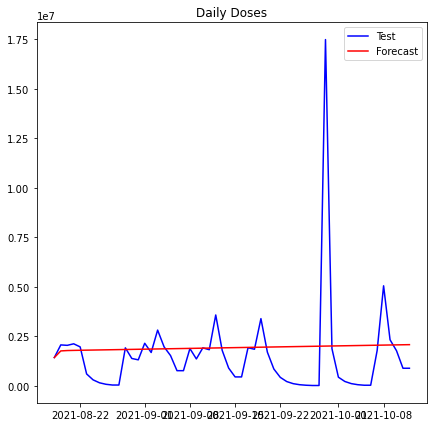

In [42]:
plot_fore_test(test_original[['undiff_Total_Doses']], fore_original_3[['undiff_Total_Doses']], title='Daily Doses')

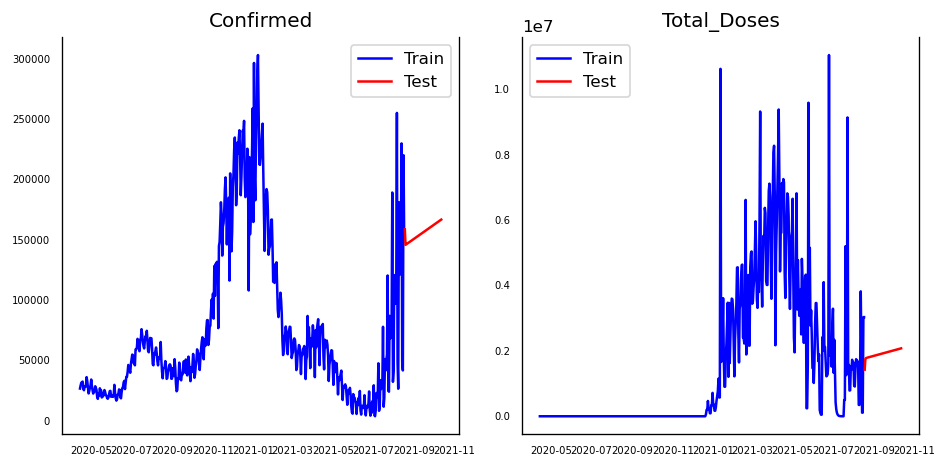

In [43]:
plot_subplots([train_original, fore_original_3])

<a name=roll2></a>

## Rolling Forecasts

In [44]:
history = train.copy()
predicted = test.copy()

for t in range(len(test)):
    model = VARMAX(history, order=(1,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()
    
    
    newindex = history.index[-1] + pd.to_timedelta(1, 'D')
    
    predicted.loc[newindex]['Confirmed'] = yhat['Confirmed']
    predicted.loc[newindex]['Total_Doses'] = yhat['Total_Doses']
    
    history = history.append(test.iloc[t])
#     history[newindex]['Total_Doses'] = test.iloc[t]['Total_Doses']
    
    print('predicted =', yhat.values, ' ; actual =', test.iloc[t].values)

predicted = [[-14495.52558533 397024.49499011]]  ; actual = [ -1567. 638061.]
predicted = [[ -7510.2012487  -72530.89628842]]  ; actual = [ 88515. -21727.]
predicted = [[-57171.94941754 220629.83102307]]  ; actual = [-179616.   77449.]
predicted = [[  44459.56051995 -318445.903936  ]]  ; actual = [ -29998. -155592.]
predicted = [[  92479.12520947 -353498.62103464]]  ; actual = [  202048.  -1365457.5]
predicted = [[ -77605.61542161 1256488.44554493]]  ; actual = [ -81329.   -298798.25]
predicted = [[ -10976.06196186 1072203.05377348]]  ; actual = [  13003.    -149399.125]
predicted = [[   4262.73622638 1143822.29152089]]  ; actual = [ 14745.     -74699.5625]
predicted = [[ -20155.00548825 1101366.10748266]]  ; actual = [ 58573.      -37349.78125]
predicted = [[ -30081.46761846 1131403.89246302]]  ; actual = [-182400.       0.]
predicted = [[ 63644.52689275 660250.09504647]]  ; actual = [ -18493.      1877420.21875]
predicted = [[ 109179.97255361 -916144.34203671]]  ; actual = [ 217837. 

In [45]:
fore_original_4 = invert_transformation(predicted, indexed.iloc[start_index:])

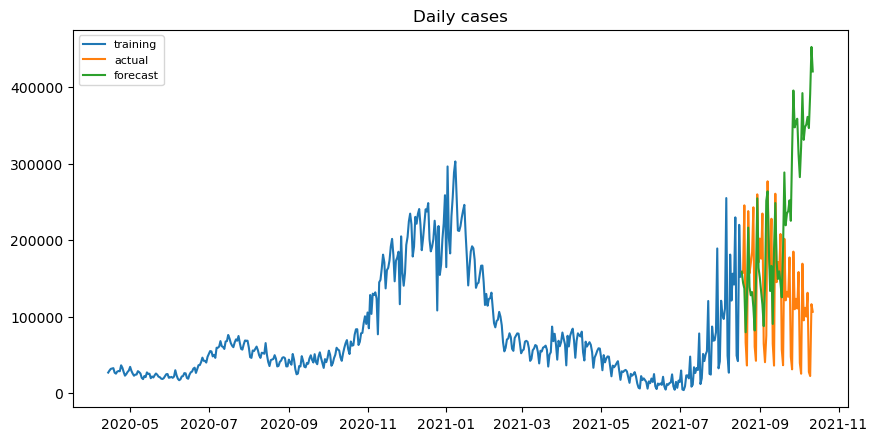

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [46]:
plot_train_test_fore(train_original.Confirmed, test_original[['undiff_Confirmed']], fore_original_4[['undiff_Confirmed']], title='Daily cases', figpath='../../figures/varma/usa_cases.eps')



In [47]:
mape_cases = MAPE(test_original[['undiff_Confirmed']], fore_original_4[['undiff_Confirmed']], title="Daily cases")


MAPE of Daily cases is 199.5382848616482%


In [48]:
mean_absolute_error(test_original[['undiff_Confirmed']], fore_original_4[['undiff_Confirmed']])

122319.27964115758